### Lista de exercícios - exercício 6.3

**Aluno:** André F. Oliveira

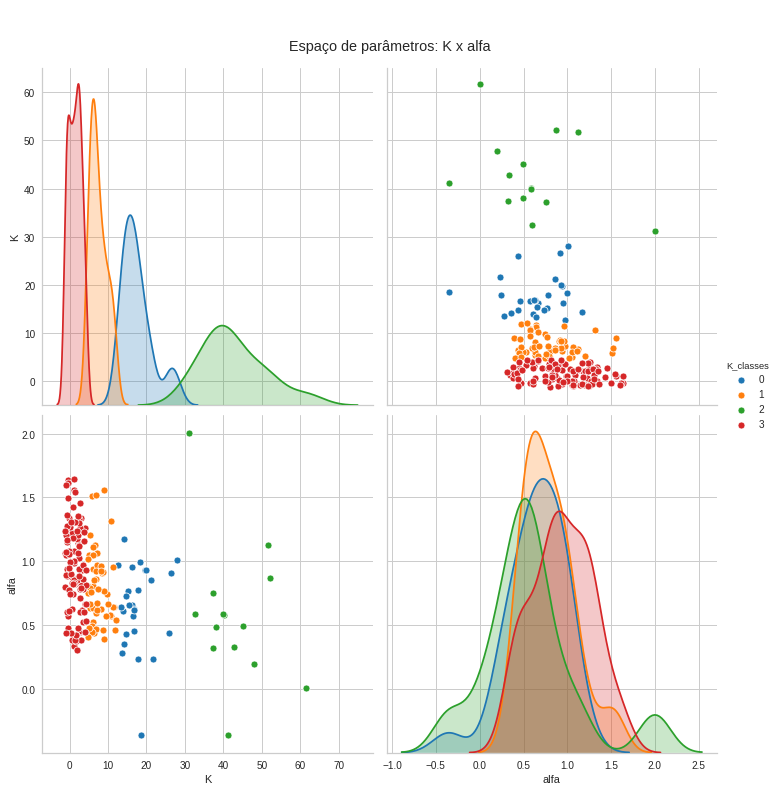



****************** Países na classe 0 ******************
                                          K      alfa  K_classes
country                                                         
Bermuda                           14.081920  0.354526          0
Gambia                            13.953041  0.612457          0
Benin                             25.943270  0.436894          0
Paraguay                          17.820072  0.776529          0
Liechtenstein                     18.328777  0.998564          0
Central African Republic          13.583725  0.280639          0
Fiji                              19.718885  0.935777          0
Dominica                          16.204222  0.955446          0
Falkland Islands                  21.602507  0.236621          0
Haiti                             16.588106  0.570562          0
Japan                             12.693744  0.968297          0
French Polynesia                  13.370984  0.644485          0
Saint Lucia                    

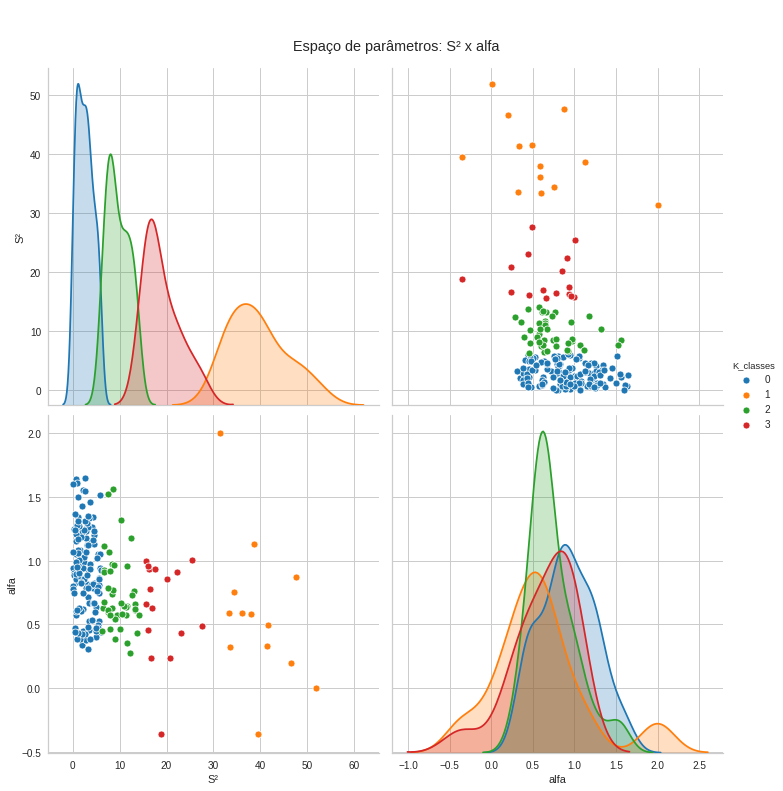



****************** Países na classe 0 ******************
                                    S²      alfa  K_classes
country                                                    
Myanmar                       3.330995  0.930930          0
Norway                        3.085681  1.271770          0
Bahrain                       4.457145  0.822789          0
Argentina                     2.235261  0.618813          0
Bulgaria                      0.992473  0.830977          0
Gibraltar                     5.868241  0.942236          0
Brunei                        4.045102  0.817047          0
Zimbabwe                      4.844485  0.636221          0
Sudan                         5.631914  0.525486          0
Jamaica                       3.190235  0.716049          0
Cape Verde                    5.448659  0.496140          0
Moldova                       0.100975  0.944247          0
Saudi Arabia                  0.630271  1.636442          0
South Africa                  4.103420  1

In [6]:
#SPECPLUS.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Created on Mon Nov 11 04:26:21 2019
@author: reinaldo
"""
__authors__ = 'Paulo Giovani & Reinaldo Rosa'
__copyright__ = 'Copyright 2017, 3DBMO Project INPE'
__credits__ = ['Paulo Giovani', 'Reinaldo Roberto Rosa', 'Murilo da Silva Dantas']
__license__ = 'GPL'
__version__ = '0.1B'
__maintainer__ = 'Paulo Giovani'
__email__ = 'pg_faria@yahoo.com.br'

# ------------------------------------------------------------------------
# Specplus.pyplot
# ------------------------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, optimize
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from glob import glob
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)

#---------------------------------------------------------------------

# Calcula o DFA 1D da série temporal

#---------------------------------------------------------------------

def dfa1d(timeSeries, grau):
    """Calcula o DFA 1D (adaptado de Physionet), onde a escala cresce
    de acordo com a variável 'Boxratio'. Retorna o array 'vetoutput', 
    onde a primeira coluna é o log da escala S e a segunda coluna é o
    log da função de flutuação."""

    # 1. A série temporal {Xk} com k = 1, ..., N é integrada na chamada função perfil Y(k)
    x = np.mean(timeSeries)
    timeSeries = timeSeries - x
    yk = np.cumsum(timeSeries)
    tam = len(timeSeries)

    # 2. A série (ou perfil) Y(k) é dividida em N intervalos não sobrepostos de tamanho S
    sf = np.ceil(tam / 4).astype(np.int)
    boxratio = np.power(2.0, 1.0 / 8.0)
    vetoutput = np.zeros(shape = (1,2))

    s = 4
    while s <= sf:        
        serie = yk        
        if np.mod(tam, s) != 0:
            l = s * int(np.trunc(tam/s))
            serie = yk[0:l]
            
        t = np.arange(s, len(serie), s)
        v = np.array(np.array_split(serie, t))
        l = len(v)
        x = np.arange(1, s + 1)

        # 3. Calcula-se a variância para cada segmento v = 1,…, n_s:
        p = np.polynomial.polynomial.polyfit(x, v.T, grau)
        yfit = np.polynomial.polynomial.polyval(x, p)
        vetvar = np.var(v - yfit)

        # 4. Calcula-se a função de flutuação DFA como a média das variâncias de cada intervalo
        fs = np.sqrt(np.mean(vetvar))
        vetoutput = np.vstack((vetoutput,[s, fs]))

        # A escala S cresce numa série geométrica
        s = np.ceil(s * boxratio).astype(np.int)

    # Array com o log da escala S e o log da função de flutuação   
    vetoutput = np.log10(vetoutput[1::1,:])

    # Separa as colunas do vetor 'vetoutput'
    x = vetoutput[:,0]
    y = vetoutput[:,1]

    # Regressão linear
    slope, intercept, _, _, _ = stats.linregress(x, y)

    # Calcula a reta de inclinação
    predict_y = intercept + slope * x

    # Calcula o erro
    pred_error = y - predict_y

    # Retorna o valor do ALFA, o vetor 'vetoutput', os vetores X e Y,
    # o vetor com os valores da reta de inclinação e o vetor de erros
    return slope, vetoutput, x, y, predict_y, pred_error




def k_means(df):
    
    # Variável auxiliar para separar os espaços de parâmetros
    tmp = ['S²','K']
    
    for n in tmp:
        
        # Definindo o nome de n atual
        if n == 'S²':
            name = 'K'
        elif n == 'K':
            name = 'S²'
            
        # Fazendo uma cópia do arquivo de entrada para renovar os valores a cada loop
        data = df.copy()
        
        # Retirando uma das colunas (alfa ou beta) para separar os espaços de parâmetros
        data = data.drop(n, axis=1)
              
        # Descobrindo o k ótimo
        model = KMeans()
        visualizer = KElbowVisualizer(model, k=10)
        visualizer.fit(data)
        plt.close()

        # Aplicando o k-means
        n_clusters = visualizer.elbow_value_ #Número ótimo de clusters
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(data)
        data['K_classes'] = kmeans.labels_

        #Plotando as relações a pares de cada medida estatística (seaborn)
        colors = sns.color_palette('tab10',n_clusters)
        
        try:
            g = sns.pairplot(data, 'K_classes', palette=colors, height=5)
            g.fig.suptitle('\n\nEspaço de parâmetros: '+name+' x alfa', y=1.08)
            plt.show()
        except ValueError:
            print('\nOs dados não apresentam variância')
        except RuntimeError:
            print('\nOs dados não apresentam variância')
        
        for classe in sorted(pd.unique(data['K_classes'])):
            print(f'\n\n****************** Países na classe {classe} ******************')
            print(data.loc[data['K_classes']==classe])
            
        print('\n\n==================================== END OF THE LOOP ====================================\n\n')
    
      
        
#---------------------------------------------------------------------

# Trecho principal

#---------------------------------------------------------------------

def main():

    """Função com o código principal do programa."""

    # Desabilita as mensagens de erro do Numpy (warnings)
    old_settings = np.seterr(divide = 'ignore', invalid = 'ignore', over = 'ignore')

    name = []
    assimetria_ = []
    curtose_ = []
    alfa_ = []
    
    # Lista todos os arquivos txt no diretório
    txt_files = glob('owd/*.txt')
    
    for file in txt_files:
        num_lines = sum(1 for line in open(file))
        
        if num_lines > 20:
            
            name.append(file.split('.')[0].split('/')[1])
            data = np.genfromtxt(file,delimiter=' ',dtype='float32',filling_values=0)


            # Para cada arquivo calcule S² e K
            assimetria_.append(stats.skew(data)**2)
            curtose_.append(stats.kurtosis(data))


            #-----------------------------------------------------------------

                # Cálculo do DFA

            #-----------------------------------------------------------------

            # Calcula o DFA 1D
            alfa, vetoutput, x, y, reta, erro = dfa1d(data, 1)
            alfa_.append(alfa)      


            #---------------------------------------------------------------------

            # Trecho principal

            #---------------------------------------------------------------------
        
    df_stats = pd.DataFrame(np.transpose([name,assimetria_,curtose_,alfa_]), 
                                         columns=['country','S²','K','alfa']).set_index('country')
    
    # Remove NaN
    df_stats = df_stats.replace('nan',np.NaN).dropna().astype('float32')
    
    espaço_parametros = k_means(df_stats)
      
    
if __name__ == "__main__":
    main()

### Espaço K x $\alpha$

Inicialmente, não parece haver um motivo muito claro para a forma como os países foram alocados no espaço de parâmetros K x $\alpha$. Por exemplo, o Brasil foi alocado no grupo 3 junto a Nova Zelândia, Coréia do Sul, Austrália, Áustria e Israel, países que sabidamente lidaram ou estão lidando muito bem com a pandemia e cujos casos já atingiram um pico e estão em grande declínio. Já os países no cluster de número 1 parecem ser aqueles que também já atingiram seu pico da doença, ou estão próximos disso, mas ainda tem um quantidade razoável de casos diários, mesmo que no geral este número esteja diminuindo. Exemplos são Estados Unidos, França, Itália e Singapura. 

Outro grupo interessante do espaço K x $\alpha$ é o cluster de número 2, composto em sua maioria por países pouco ou quase nunca citados nessa pandemia, como Palestina, Nepal, Mongolia, Nicarágua e, seu membro mais ilustre, a China. Em um primeiro momento, não parece haver nenhuma razão aparente para alocar países tão distintos em um mesmo cluster. No entanto, o motivo para isso ter acontecido parece ser o grande número de novos casos iguais a zero em todos estes países. Apesar da China ter sido o local de origem do vírus, o país conseguiu conter seu avanço relativamente cedo e hoje é apenas o 17º em número de casos com 83021 no total. Por ter poucos ou nenhum novo caso diário desde o [começo de março](https://www.worldometers.info/coronavirus/country/china/), o arquivo de dados sobre a China contém muitos valores pequenos ou iguais a zero, fazendo com que ela fosse alocada junto a países com uma quantidade até mesmo irrisória de casos.

### Espaço S² x $\alpha$

Não houveram muitas alterações na distribuição dos países neste espaço de parâmetros com relação ao anterior. Os "pontos fora da curva" continuam sendo os países com poucos casos ainda acompanhados de China. Talvez a mudança mais relevante seja justamente com relação ao Brasil. Desta vez o país foi alocado junto à maioria dos demais no cluster 0, que também contém países muito citados nesta pandemia, como Itália, Estados Unidos, Espanha, Suécia, entre outros. Já o cluster 3 parece novamente ter agrupado a maior parte dos países que melhor estão lidando com a pandemia, como Nova Zelândia, Austrália e Coréia do Sul. A distribuição de casos destes países é caracterizada por ter um comportamento que se aproxima de uma gaussiana, ou seja, poucos casos no começo, um pico pouco acentuado e um  declínio rápido no final.

De maneira geral, o segundo espaço de parâmetros parece ter feito uma melhor separação dos países entre faixas que fazem mais sentido do ponto de vista do que é sabido da doença e da situação de cada um desses países. Obviamente podem haver mudanças conforme os números se atualizam, mas até o momento, dia 18/05, o algoritmo do k-means fez uma classificação satisfatória dos países utilizados na análise. 